# Project 4B (MENG 35500) - Rebecca D'Antonio

## Molecular Dynamics II

### 1) Imports

In [4]:
#imports
import os
import math
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits as tk
from numba import jit
from IPython import display
from numba import double, jit, types
import time
import copy 
from MDAnalysis.coordinates.XYZ import XYZReader

In [2]:
#magic commands
%load_ext autoreload
%autoreload 2

#inline plotting
%matplotlib inline

In [3]:
#fix numpy's random number generator seed
np.random.seed(17896)

### 2) Wrap to Periodic Boundary Conditions

In [4]:
#apply periodic boundary conditions of LxLxL cubic box to particle
#whose (x,y,z) coordinates are held in 3-element vector r
def wrap(r, L): 
    
    #r[0]=x, r[1]=y, r[2]=z
    
    #if x < l, x = x+L
    if (r[0] < L): 
        r[0] = r[0] + L
    #if x > L, x = x-L
    if (r[0] > L): 
        r[0] = r[0] - L
    #if x = L, map back to 0
    if (r[0] == L):
        r[0] = 0
        
        
    #if y < l, y = y+L
    if (r[1] < L): 
        r[1] = r[1] + L
    #if y > L, y = y-L
    if (r[1] > L): 
        r[1] = r[1] - L
    #if y = L, map back to 0
    if (r[1] == L):
        r[1] = 0
        
    #if z < l, z = z+L
    if (r[2] < L): 
        r[2] = r[2] + L
    #if z > L, z = z-L
    if (r[2] > L): 
        r[2] = r[2] - L
    #if z = L, map back to 0
    if (r[2] == L):
        r[2] = 0
    
    return r

### 3) Minimum Image Distance

In [5]:
#compute minimum image distance between 2 atoms whose (x,y,z) 
#coordinates are held in 3-element vectors r1 and r2
def dist(r1, r2, L): 
    
    #first wrap both atoms to make sure inside box
    r1 = wrap(r1, L)
    r2 = wrap(r2, L)
    
    #define dx, dy, and dz as the absolute values of the differences 
    #in each coordinate direction per vector
    dx = abs(r1[0] - r2[0])
    dy = abs(r1[1] - r2[1])
    dz = abs(r1[2] - r2[2])
    
    #if any of the distances (in x,y,z direction) are greater than half the
    #length of the box, the minimum image distance should be re defined as 
    # L - the original separation
    if (dx > L/2): 
        dx = L - dx
    if (dy > L/2): 
        dy = L - dy
    if (dz > L/2): 
        dz = L - dz
    
    #distance equation (magnitude)
    d = math.sqrt((dx)**2+(dy)**2+(dz)**2)
    
    return d  

In [6]:
# pairwise distance vector
def dist_v(r1,r2,L):
    
    halfL = L/2.
    
    r12 = r2-r1
    
    for ii in range(3):
        if r12[ii] > halfL:
            r12[ii] -= L
        elif r12[ii] < -halfL:
            r12[ii] += L

    return r12

In [7]:
#compute distance with no PBC
def dist_noPBC(r1, r2):
    
    dx = abs(r1[0] - r2[0])
    dy = abs(r1[1] - r2[1])
    dz = abs(r1[2] - r2[2])
    
    d = math.sqrt((dx)**2+(dy)**2+(dz)**2)
    
    return d  
    

### 4) Pairwise Energy

In [8]:
#compute energy between 2 particles i and j separated by a distance
#r according to the truncated and shifted Lennard-Jones potential
def E_ij(r, sigma, epsilon, rc):
    
    LJ = 0 
    if abs(r) <= rc:
        #lennard jones formula for energy for r
        q6 = (sigma/r)**6
        q12 = q6**2
        LJ_r = 4*epsilon*(q12-q6)
        #lennard jones formula for energy for rc
        q6 = (sigma/rc)**6
        q12 = q6**2
        LJ_rc = 4*epsilon*(q12-q6)
        #truncated-shifted:
        LJ = LJ_r - LJ_rc

    return LJ

### 5) Pairwise Force

In [9]:
#compute the force on particle i exerterd by particle j under the truncated
# and shifted Lennard-Jones potential, wheere r = r_ij = r_j - r_i
@jit((double[:])(double[:], double, double, double),nopython=True)
def f_ij(r, sigma, epsilon, rc):

    s = math.sqrt(r[0]**2+r[1]**2+r[2]**2)
    
    if s <= rc:

        q6 = (sigma/s)**6
        q12 = q6**2
        
        f = -(48*epsilon/s**2)*(q12 - 0.5*q6)*r # zJ/nm
        
    else:
        
        f = 0.*r
    
    return f

### 6) Tail Corrections

In [10]:
#return the tail corrections to the system energy 
def E_tail(N, L, sigma, epsilon, rc):
    
    q3c = (sigma/rc)**3
    q9c = q3c**3
    
    Etail = 8.*np.pi*(N**2)*epsilon*(sigma**3)/(3.*L**3)*( q9c/3. - q3c ) # zJ
    
    return Etail

In [11]:
#return the tail corrections to the system pressure
def P_tail(N, L, sigma, epsilon, rc):
    
    q3c = (sigma/rc)**3
    q9c = q3c**3
    
    Ptail = 16.*np.pi*(N**2)*epsilon*(sigma**3)/(3.*L**6)*( (2./3.)*q9c - q3c )
    
    Ptail *= 1E-21*(1E9)**3/1E5 # bar
    
    return Ptail

### 7) Coordinate Initialization - random

In [12]:
#randomly position the N Ar atoms within the cubic box of side length L
#avoiding collisions between particles at distances closer than sigma
def init_rand(N, L, sigma):
    
    #initialize xyz as N x 3 matrix
    xyz = np.zeros((N, 3))
    
    for i in range(0,N): 
        
        #create a test array for positions, only accept the position at i if not within sigma of any other positions
        pos = np.zeros((N, 3))
        pos[i] = np.random.random(3)*L
        
        #loop through all positions, only accept the position at i if not within sigma of any other atoms
        count = 0
        while (count < i):
    
            #if within sigma, create new random position
            if (dist(xyz[count], pos[i], L) < sigma):
                
                pos[i] = np.random.random(3)*L
                count = 0 
                
            count+=1
        
        #accept position, add it to xyz
        xyz[i] = pos[i]
       
    return xyz

### 8) Coordinate Initialization - crystal

In [13]:
#position the N Ar atoms within the cubic box of side length L on a 
#simple cubic crystal lattice
def init_xtal(N, L):
    
    #initialize empty position array that is 3 dimensions (xyz) x the number of atoms
    pos = np.zeros((N, 3))
    
    #take the cubic root of the total number of atoms to find the number in a single dimension
    nPerSide = int(np.ceil(pow(N,(1.0/3.0)))) 
       
    #initialize every position of atoms in a 3D box, dependent on the desntiy (length of the side, number of atoms per that length)
    counter = 0 #start at position 0
    for i in range(0,nPerSide): #x
        for j in range(0,nPerSide): #y
            for k in range(0,nPerSide): #z
                if (counter < N):
                    #initialize positions at #(x,y,z)*L/dimension
                    pos[counter, 0] = i*L/nPerSide
                    pos[counter, 1] = j*L/nPerSide
                    pos[counter, 2] = k*L/nPerSide
                    counter += 1 
                    
    return pos

### 9) Velocity Initialization

In [2]:
#assign velocities of the N particles as random draws from the Maxwell-Boltzmann
#distribution at temperature T
def vMaxBoltz(T, N, m):
    
    NAv = 6.02E23 
    kB = 1.38064852e-2 #zJ/K
    
    stdev = np.sqrt(kB*T*1E-21/(m/(1000.*NAv)))*1E9/1E12 # nm/ps
    v_xyz = np.random.normal(0.,stdev,(N,3))
    
    mean = np.mean(v_xyz,axis=0) 
    for i in range(3): 
        v_xyz[:,i] -= mean[i] 
        
    return v_xyz #nm/ps

### 9) Energy

In [15]:
#compute the total potential energy of the system
def E_pot(xyz, L, sigma, epsilon, rc):
    
    N = xyz.shape[0]
    
    #initialize system E ot 0
    Epot = 0
    
    #loop through pairwise interactions between ALL atoms
    for ii in range(N):
        r1 = xyz[ii,:]
        for jj in range(ii):
            r2 = xyz[jj,:]
            d = dist(r1,r2,L)
            #then add pairwise energy between i and each particle in system to total
            Epot += E_ij(d,sigma,epsilon,rc)
    
    return Epot

In [16]:
#compute the instantaenous kinetic energy
def E_kin(v_xyz, m):
    
    NAv = 6.02E23
    
    Ekin = 0.5*(m/(1000.*NAv))*np.sum(v_xyz**2)*((1E12/1E9)**2)*1E21 # zJ
    
    return Ekin

### 10) Pressure

In [17]:
#compute the pressure in the simulation box using virial equation 
def pressure(N, L, T, xyz, sigma, epsilon, rc):
    
    kB = 1.38064852E-2
    
    P_kinetic = (N/(L*1E-9)**3)*kB*1E-21*T # Pa
    
    P_virial = 0
    for i in range(N):
        ri = xyz[i,:]
        for j in range(i):
            rj = xyz[j,:]
            rij = dist_v(ri,rj,L)
            fij = f_ij(rij,sigma,epsilon,rc)
            P_virial += np.dot(rij,fij)
    P_virial *= 1E-21/(3*(L*1E-9)**3) # Pa
    
    P_kinetic /= 1E5 # bar
    
    P_virial /= 1E5 # bar
    
    return (P_kinetic-P_virial)

### 11) Temperature

In [18]:
#compute instantaneous temperature using equipartition
def temperature(v_xyz, m, N):
    
    kB = 1.38064852E-2
    
    Ekin = E_kin(v_xyz, m)
    
    T = (2. * Ekin) / (3. * N * kB)
    
    return T

### 12) Coordinate write

In [19]:
#write current (x,y,z) coordinate triplets of all N atoms in system
#to file in xyz-format
def xyzWrite(xyz, outfile, writestyle):
    
    #either open the file as write or append 
    if (writestyle == 'w'): 
        outFile = open(outfile, 'w')
    if (writestyle == 'a'):
        outFile = open(outfile, 'a')
    
    #write to file in xyz format
    N = xyz.shape[0]
    outFile.write("%d\n" % N)
    outFile.write("\n")
  
    for i in range(0, xyz.shape[0]):
        #nm->angstroms
        outFile.write("Ar %6.2f %6.2f %6.2f\n" % (xyz[i,0]*10, xyz[i,1]*10, xyz[i,2]*10))
     
    outFile.close()    

In [20]:
#write current (x,y,z) velocity trajectories of all N atoms in system
#to file in xyz-format
def v_xyzWrite(v_xyz, outfile, writestyle):
    
    #either open the file as write or append 
    if (writestyle == 'w'): 
        outFile = open(outfile, 'w')
    if (writestyle == 'a'):
        outFile = open(outfile, 'a')
    
    #write to file in xyz format
    N = v_xyz.shape[0]
    outFile.write("%d\n" % N)
    outFile.write("\n")
  
    for i in range(0, v_xyz.shape[0]):
        #nm->angstroms
        outFile.write("Ar %6.2f %6.2f %6.2f\n" % (v_xyz[i,0]*10, v_xyz[i,1]*10, v_xyz[i,2]*10))
     
    outFile.close()   

In [21]:
#write current box length to file
def L_Write(L, outfile, writestyle):
    
    #either open the file as write or append 
    if (writestyle == 'w'): 
        outFile = open(outfile, 'w')
    if (writestyle == 'a'):
        outFile = open(outfile, 'a')
    
    #write to file
    N = v_xyz.shape[0]
    outFile.write("%d\n" % N)
    outFile.write("\n")
  
    for i in range(0, v_xyz.shape[0]):
        #nm->angstroms
        outFile.write("Ar %6.2f" % L*10)
     
    outFile.close()   

### 13) Forces

In [27]:
#compute the force on each atom as a result of the pairwise forces due to 
#all of its neighbors
def forces(N, xyz, L, sigma, epsilon, rc):
    
    f_xyz = np.zeros((N,3))
    
    for i in range(N):
        ri = xyz[i,:]
        for j in range(i):
            rj = xyz[j,:]
            rij = dist_v(ri,rj,L)
            fij = f_ij(rij,sigma,epsilon,rc) # zJ/nm
            f_xyz[i,:] += fij
            f_xyz[j,:] -= fij
    
    return f_xyz

### 14) Velocity Verlet

In [23]:
#velocity verlet update step
def velocityVerlet(N, xyz, v_xyz, L, sigma, epsilon, rc, m, dt, T_targ, tau_T, P_targ, tau_P):
    
    f_ber = np.zeros((N, 3))
    gamma = 4.6e-5
    NAv = 6.02E23
       
    if (tau_P != 0):
        
        T = temperature(v_xyz, m, N)
        
        Ptail = P_tail(N, L, sigma, epsilon, rc)
        Pres = pressure(N, L, T, xyz, sigma, epsilon, rc)
        Pres = Pres + Ptail
        
        n = 1 - ((dt/tau_P)*gamma*(P_targ - Pres))
        scale = n**(1.0/3.0)
        
        if ((L*scale/2) > rc):
            L *= scale
            xyz *= scale
            
    if (tau_T != 0):
        
        f_xyz = forces(N, xyz, L, sigma, epsilon, rc)

        T = temperature(v_xyz, m, N)
        
        f_ber = (m/2/tau_T)*( (T_targ/T) - 1)*v_xyz
        
        force = f_xyz + f_ber

        v_xyz = v_xyz + (dt*1E-12/(2.*(m/(1000.*NAv))))*force*1E-21*1E9*1E9*1E-12 

        xyz = xyz + (v_xyz)*dt

        for atom in range(0, N):

            xyz[atom,:] = wrap(xyz[atom,:], L)

        f_xyz = forces(N, xyz, L, sigma, epsilon, rc)

        T = temperature(v_xyz, m, N)
        
        f_ber = (m/2/tau_T)*( (T_targ/T) - 1)*v_xyz
        
        force = f_xyz + f_ber

        v_xyz = v_xyz + (dt*1E-12/(2.*(m/(1000.*NAv))))*force*1E-21*1E9*1E9*1E-12 
          
    
    if(tau_T == 0 and tau_P == 0): 
             
        f_xyz = forces(N, xyz, L, sigma, epsilon, rc)

        v_xyz = v_xyz + (dt*1E-12/(2.*(m/(1000.*NAv))))*f_xyz*1E-21*1E9*1E9*1E-12 

        xyz = xyz + (v_xyz)*dt

        for atom in range(0, N):

            xyz[atom,:] = wrap(xyz[atom,:], L)

        f_xyz = forces(N, xyz, L, sigma, epsilon, rc)

        v_xyz = v_xyz + (dt*1E-12/(2.*(m/(1000.*NAv))))*f_xyz*1E-21*1E9*1E9*1E-12 


    return xyz, v_xyz, L
    

### 15) User Input

In [147]:
T = float(input("Target Temperature: "))
P = float(input("Target Pressure: "))
L = float(input("Cubic Box Side Length: "))
N = int(input("Number of Atoms: "))
dt = float(input("Molecular Dynamics Time Step: "))
nSteps = int(input("Number of MD Steps: "))
rc = float(input("Lennard-Jones cutoff: "))
printModulus = int(input("Frequency of Prints to Screen: "))
writeModulus = int(input("Freqeuncy of Writes to File: "))
sigma = float(input("Lennard-Jones Size Paramater for Ar: "))
epsilon = float(input("Lennard-Jones Energy Parameter: "))
m = float(input("Molecular Weight for Ar: "))
kB = float(input("Boltzmann's constant: "))
tau_T = float(input("Thermostat time: "))
tau_P = float(input("Barostat time: "))

Target Temperature: 298
Target Pressure: 200
Cubic Box Side Length: 2.4
Number of Atoms: 100
Molecular Dynamics Time Step: 0.0005
Number of MD Steps: 10000
Lennard-Jones cutoff: 1.1
Frequency of Prints to Screen: 100
Freqeuncy of Writes to File: 100
Lennard-Jones Size Paramater for Ar: 0.34
Lennard-Jones Energy Parameter: 1.65
Molecular Weight for Ar: 39.948
Boltzmann's constant: 1.38064852E-2
Thermostat time: 0.1
Barostat time: 0.001


### 16) Molecular Dynamics Main Loop

In [24]:
#Molecular Dynamics Main Loop
def MDML(T, P, L, N, dt, nSteps, rc, printModulus, writeModulus, sigma, epsilon, m, tau_T, tau_P, xyz, v_xyz):
    
    #if starting positions and velocities are not defined
    if (len(xyz) == 0 and len(v_xyz) == 0):
        #random configuration
        xyz = init_rand(N, L, sigma)
        v_xyz = vMaxBoltz(T, N, m)

    #for writing to outfile
    if (tau_P == 0):
        outfile = './MD_Pos_NVT.xyz'
    else:    
        outfile = './MD_Pos_NPT.xyz'
    outfile2 = './MD_Vel.xyz'
    outfile3 = './MD_L.xyz'
    
    #initializations
    EPot = 0
    EKin = 0
    Etot = 0
    Pres = 0
    Temp = 0
    Etail = 0
    Ptail = 0
    
    #for plotting
    EPot_list = np.zeros(nSteps)
    EKin_list = np.zeros(nSteps)
    ETot_list = np.zeros(nSteps)
    Pres_list = np.zeros(nSteps)
    Temp_list = np.zeros(nSteps)
    Length_list = np.zeros(nSteps)
    t_list = np.zeros(nSteps)
    
    for i in range(0, nSteps):
        
        #verlet
        xyz, v_xyz, L = velocityVerlet(N, xyz, v_xyz, L, sigma, epsilon, rc, m, dt, T, tau_T, P, tau_P)
        
        #calculations
        Etail = E_tail(N, L, sigma, epsilon, rc)
        Ptail = P_tail(N, L, sigma, epsilon, rc)
        Temp = temperature(v_xyz, m, N)
        EPot = E_pot(xyz, L, sigma, epsilon, rc)
        EPot += Etail
        EKin = E_kin(v_xyz, m)
        ETot = EPot+EKin
        Pres = pressure(N, L, Temp, xyz, sigma, epsilon, rc)
        Pres += Ptail
        
        #add data values 
        EPot_list[i] = EPot
        EKin_list[i] = EKin
        ETot_list[i] = ETot
        Pres_list[i] = Pres
        Temp_list[i] = Temp
        Length_list[i] = L
        t_list[i] = (i+1)*dt
        
        #print every printModulus Sweeps
        if(i % printModulus == 0):
            print("Kinetic Energy: %.3f" % EKin)
            print("Potential Energy: %.3f" % EPot)
            print("Total Energy: %.3f" % ETot)
            print("Temperature: %.3f" % Temp)
            print("Pressure: %.3f" % Pres)
            print("Energy Tail Correction: %.3f" % Etail)
            print("Pressure Tail Correction: %.3f" % Ptail)
            print("")
        
        #write every writeModulus Sweeps
        if(i % writeModulus == 0):
            xyzWrite(xyz, outfile, 'a')
            v_xyzWrite(v_xyz, outfile2, 'a')
            L_Write(L, outfile3, 'w')
      
    #plots
    plt.plot(t_list, EKin_list, label='$EKin(t)}$')
    plt.plot(t_list, ETot_list, label='$ETot(t)}$')
    plt.plot(t_list, EPot_list, label='$EPot(t)}$')
    plt.ylabel('Energy (zJ)')
    plt.xlabel('Time (ns)')
    plt.legend()
    plt.show()
    
    plt.plot(t_list, ETot_list, label='$ETot(t)}$')
    plt.ylabel('Total Energy (zJ)')
    plt.xlabel('Time (ns)')
    plt.legend()
    plt.show()
    
    plt.plot(t_list, EPot_list, label='$EPot(t)}$')
    plt.ylabel('Potential Energy (zJ)')
    plt.xlabel('Time (ns)')
    plt.legend()
    plt.show()
    
    plt.plot(t_list, EKin_list, label='$EKin(t)}$')
    plt.ylabel('Kinetic Energy (zJ)')
    plt.xlabel('Time (ns)')
    plt.legend()
    plt.show()
    
    plt.plot(t_list, Pres_list, label='$Pres(t)}$')
    plt.ylabel('Pressure (bar)')
    plt.xlabel('Time (ns)')
    plt.legend()
    plt.show()
    
    plt.plot(t_list, Temp_list, label='$Temp(t)}$')
    plt.ylabel('Temperature (K)')
    plt.xlabel('Time (ps)')
    plt.legend()
    plt.show()
    
    plt.plot(t_list, Length_list, label='$Length(t)}$')
    plt.ylabel('Length (nm)')
    plt.xlabel('Time (ns)')
    plt.legend()
    plt.show()
    
    return xyz, v_xyz, L


### 17) Self-Diffusivity

Start from no previous configuration:

In [29]:
xyz = np.zeros(0)
v_xyz = np.zeros(0)

#### NPT Run:

Kinetic Energy: 609.125
Potential Energy: -271.229
Total Energy: 337.896
Temperature: 294.125
Pressure: 97.271
Energy Tail Correction: -11.630
Pressure Tail Correction: -16.861

Kinetic Energy: 600.197
Potential Energy: -275.804
Total Energy: 324.393
Temperature: 289.814
Pressure: 210.567
Energy Tail Correction: -12.556
Pressure Tail Correction: -19.654

Kinetic Energy: 602.205
Potential Energy: -270.090
Total Energy: 332.115
Temperature: 290.784
Pressure: 205.349
Energy Tail Correction: -12.280
Pressure Tail Correction: -18.800

Kinetic Energy: 608.281
Potential Energy: -271.658
Total Energy: 336.622
Temperature: 293.717
Pressure: 201.009
Energy Tail Correction: -12.193
Pressure Tail Correction: -18.534

Kinetic Energy: 609.508
Potential Energy: -269.910
Total Energy: 339.598
Temperature: 294.310
Pressure: 205.887
Energy Tail Correction: -12.121
Pressure Tail Correction: -18.314

Kinetic Energy: 617.092
Potential Energy: -275.611
Total Energy: 341.481
Temperature: 297.972
Pressure: 19

Kinetic Energy: 616.174
Potential Energy: -193.464
Total Energy: 422.710
Temperature: 297.529
Pressure: 200.047
Energy Tail Correction: -8.430
Pressure Tail Correction: -8.860

Kinetic Energy: 619.732
Potential Energy: -196.524
Total Energy: 423.207
Temperature: 299.247
Pressure: 191.597
Energy Tail Correction: -8.436
Pressure Tail Correction: -8.872

Kinetic Energy: 623.303
Potential Energy: -202.670
Total Energy: 420.633
Temperature: 300.971
Pressure: 194.665
Energy Tail Correction: -8.602
Pressure Tail Correction: -9.225

Kinetic Energy: 623.619
Potential Energy: -205.348
Total Energy: 418.270
Temperature: 301.124
Pressure: 198.027
Energy Tail Correction: -8.682
Pressure Tail Correction: -9.396

Kinetic Energy: 613.072
Potential Energy: -195.209
Total Energy: 417.863
Temperature: 296.031
Pressure: 210.578
Energy Tail Correction: -8.586
Pressure Tail Correction: -9.191

Kinetic Energy: 616.333
Potential Energy: -197.216
Total Energy: 419.117
Temperature: 297.606
Pressure: 199.495
Ene

Kinetic Energy: 640.297
Potential Energy: -225.563
Total Energy: 414.734
Temperature: 309.177
Pressure: 195.021
Energy Tail Correction: -8.876
Pressure Tail Correction: -9.821

Kinetic Energy: 617.334
Potential Energy: -205.430
Total Energy: 411.904
Temperature: 298.089
Pressure: 214.423
Energy Tail Correction: -8.683
Pressure Tail Correction: -9.398

Kinetic Energy: 617.605
Potential Energy: -205.213
Total Energy: 412.391
Temperature: 298.220
Pressure: 199.330
Energy Tail Correction: -8.549
Pressure Tail Correction: -9.110

Kinetic Energy: 623.104
Potential Energy: -212.063
Total Energy: 411.042
Temperature: 300.875
Pressure: 193.744
Energy Tail Correction: -8.630
Pressure Tail Correction: -9.285

Kinetic Energy: 619.893
Potential Energy: -210.785
Total Energy: 409.108
Temperature: 299.324
Pressure: 202.245
Energy Tail Correction: -8.685
Pressure Tail Correction: -9.404

Kinetic Energy: 618.657
Potential Energy: -210.117
Total Energy: 408.540
Temperature: 298.728
Pressure: 201.673
Ene

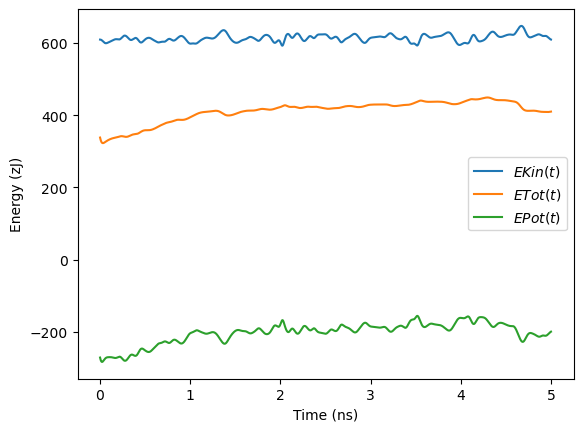

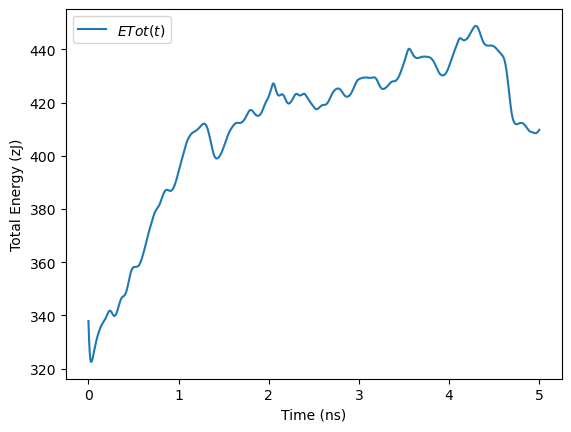

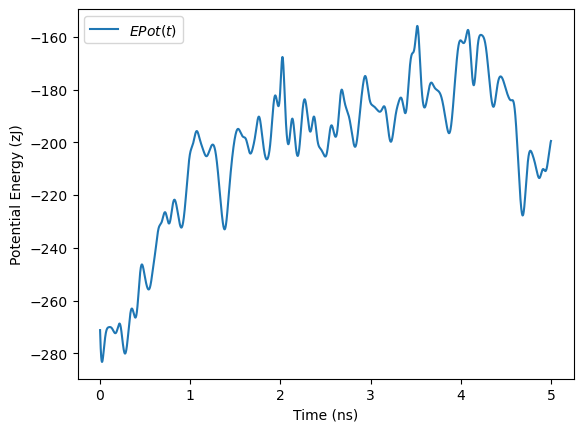

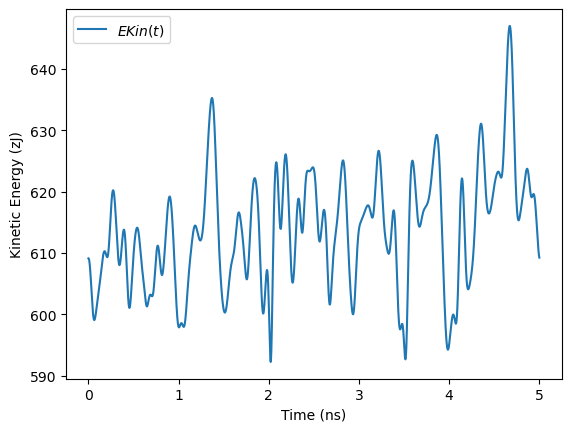

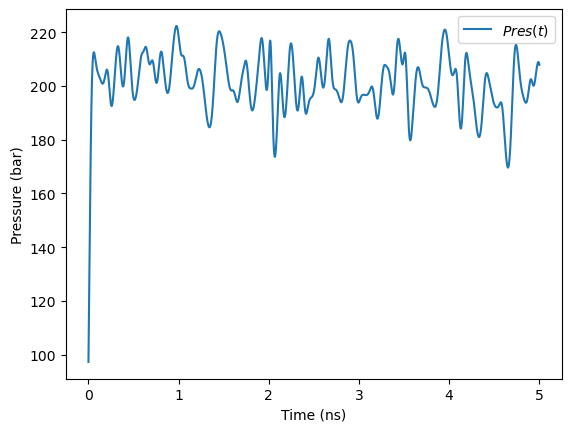

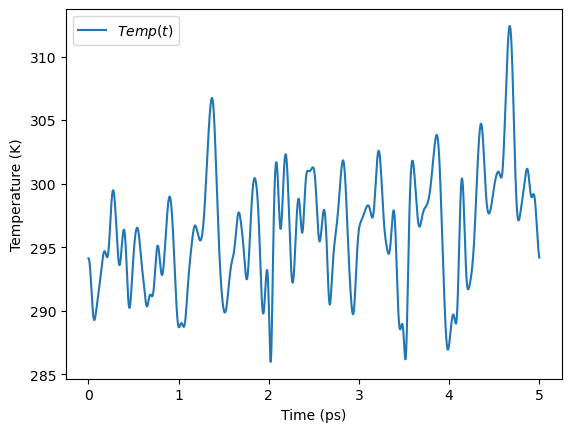

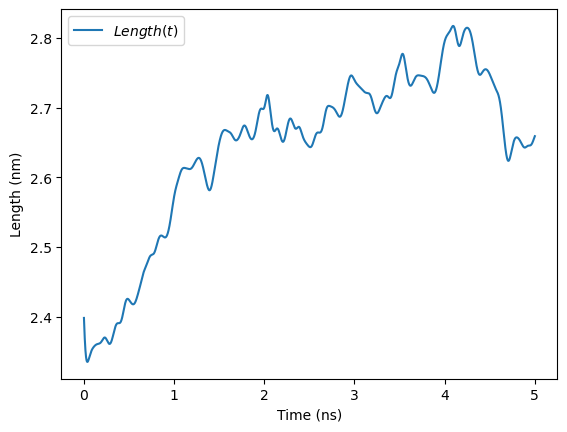

In [30]:
xyz1, v_xyz1, L1 = MDML(298, 200, 2.4, 100, 0.0005, 10000, 1.1, 100, 100, 0.34, 1.65, 39.948, 0.1, 0.001, xyz, v_xyz)

Final Side Length:

In [31]:
print(L1)

2.6589483410149954


#### NVT Run:

Kinetic Energy: 609.194
Potential Energy: -199.418
Total Energy: 409.776
Temperature: 294.158
Pressure: 207.975
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 616.245
Potential Energy: -206.121
Total Energy: 410.124
Temperature: 297.563
Pressure: 189.892
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 621.778
Potential Energy: -211.797
Total Energy: 409.980
Temperature: 300.235
Pressure: 170.433
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 627.029
Potential Energy: -217.477
Total Energy: 409.552
Temperature: 302.770
Pressure: 151.559
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 627.452
Potential Energy: -218.558
Total Energy: 408.894
Temperature: 302.975
Pressure: 146.253
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 621.598
Potential Energy: -213.154
Total Energy: 408.444
Temperature: 300.148
Pressure: 160.468
Ene

Kinetic Energy: 615.821
Potential Energy: -213.505
Total Energy: 402.317
Temperature: 297.359
Pressure: 211.682
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 611.708
Potential Energy: -209.146
Total Energy: 402.563
Temperature: 295.372
Pressure: 225.237
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 606.695
Potential Energy: -203.696
Total Energy: 402.999
Temperature: 292.952
Pressure: 238.306
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 608.158
Potential Energy: -204.459
Total Energy: 403.699
Temperature: 293.658
Pressure: 235.654
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 586.714
Potential Energy: -182.028
Total Energy: 404.686
Temperature: 283.304
Pressure: 275.130
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 616.177
Potential Energy: -210.164
Total Energy: 406.013
Temperature: 297.530
Pressure: 201.086
Ene

Kinetic Energy: 604.050
Potential Energy: -194.640
Total Energy: 409.410
Temperature: 291.675
Pressure: 244.879
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 602.421
Potential Energy: -192.198
Total Energy: 410.223
Temperature: 290.888
Pressure: 262.737
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 587.613
Potential Energy: -176.039
Total Energy: 411.573
Temperature: 283.738
Pressure: 303.148
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 613.617
Potential Energy: -200.815
Total Energy: 412.802
Temperature: 296.294
Pressure: 248.544
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 628.545
Potential Energy: -216.139
Total Energy: 412.406
Temperature: 303.502
Pressure: 207.911
Energy Tail Correction: -8.532
Pressure Tail Correction: -9.074

Kinetic Energy: 624.991
Potential Energy: -213.219
Total Energy: 411.772
Temperature: 301.786
Pressure: 209.445
Ene

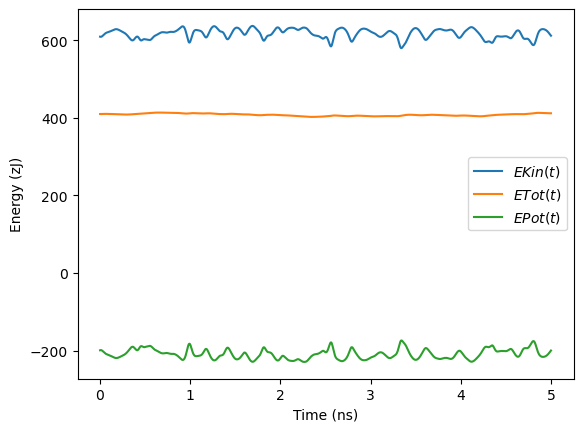

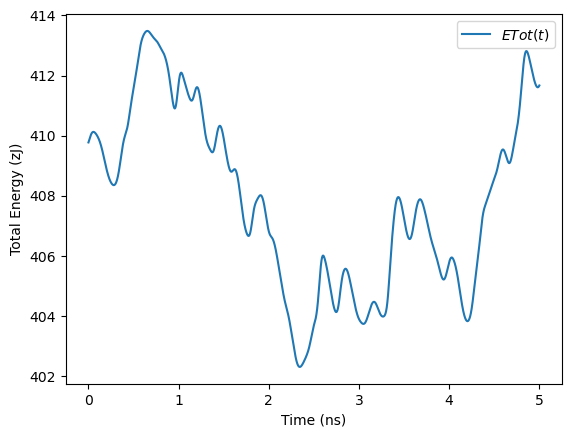

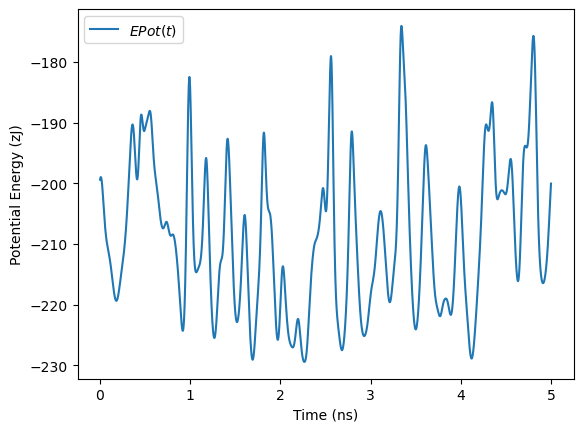

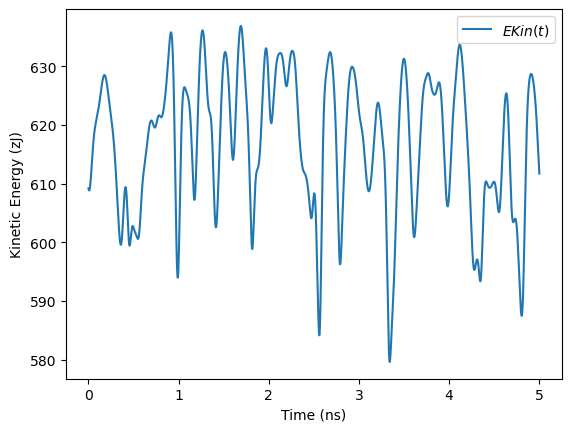

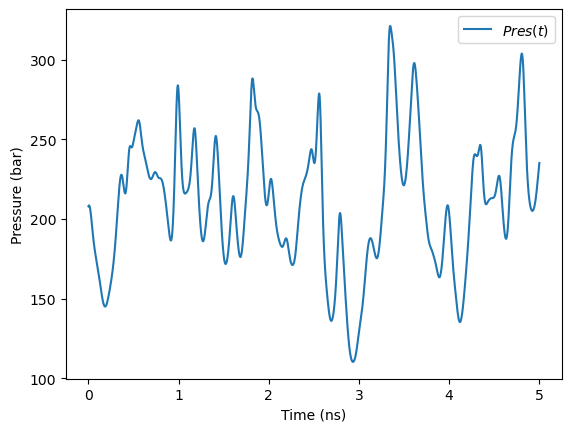

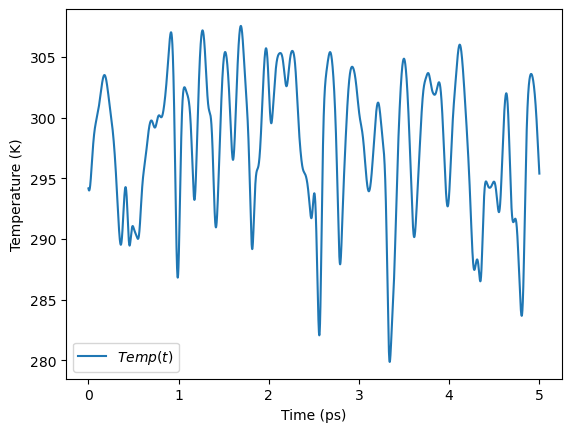

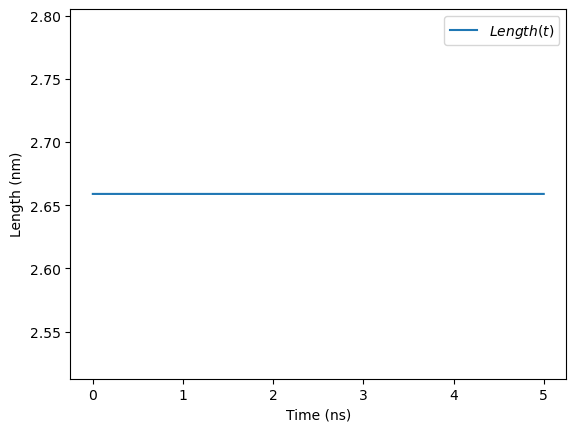

In [32]:
xyz2, v_xyz2, L2 = MDML(298, 200, L1, 100, 0.0005, 10000, 1.1, 100, 100, 0.34, 1.65, 39.948, 0.5, 0, xyz1, v_xyz1)

#### MSD Analysis

In [33]:
#load NVT trajectories into xyz array with 10000 steps/100 writes = 100 Frames
trajFile = './MD_Pos_NVT.xyz'
traj = XYZReader(trajFile)

xyz = []
for frame in range(len(traj)):
    xyz.append(np.array(copy.deepcopy(traj[frame].positions[:,:]))/10.)
    
nFrames = len(xyz)
N = xyz[0].shape[0]

In [34]:
#calculate displacement vector between particle at Frame i and Frame (i-1)
#without PBC
def disp_v(r1,r2,L):
    
    r12 = r1-r2
    r21 = r2-r1
    
    disp = np.zeros(3)
    
    for i in range(3):
        if (abs(r12[i]) > L/2): 
            if (r21[i] < 0):
                disp[i] = r21[i] + L
            if (r21[i] > 0):
                disp[i] = r21[i] - L
        else: 
            disp[i] = r21[i]

    return disp

In [35]:
#unwrap particles by recovering their true displacement (no PBC)
def unWrap(xyz, nFrames, L, N):
    
    r_sum = np.zeros((N,3))
    xyz_noPBC = np.zeros((nFrames,N,3))
    
    xyz_noPBC[0] = xyz[0]
    
    for step in range(1, nFrames):
    
        for atom in range(0, N):

            d_r = np.zeros(3)
        
            r_1 = xyz[step-1][atom,:]
            r_i = xyz[step][atom,:]

            d_r = disp_v(r_i, r_1, L)
            
            xyz_noPBC[step][atom,:] = xyz_noPBC[step-1][atom,:] + d_r

    return xyz_noPBC 

In [36]:
#restore xyz with no PBC
xyz_noPBC = unWrap(xyz, nFrames, L1, N)

In [37]:
#write this restored xyz to outfile (check not wrapping to PBC)
outfile4 = './xyz_noPBC.xyz'

nSteps = len(xyz_noPBC)

for step in range(nSteps):
    xyzWrite(xyz_noPBC[step], outfile4, 'a')

##### Terminal Snapshot:

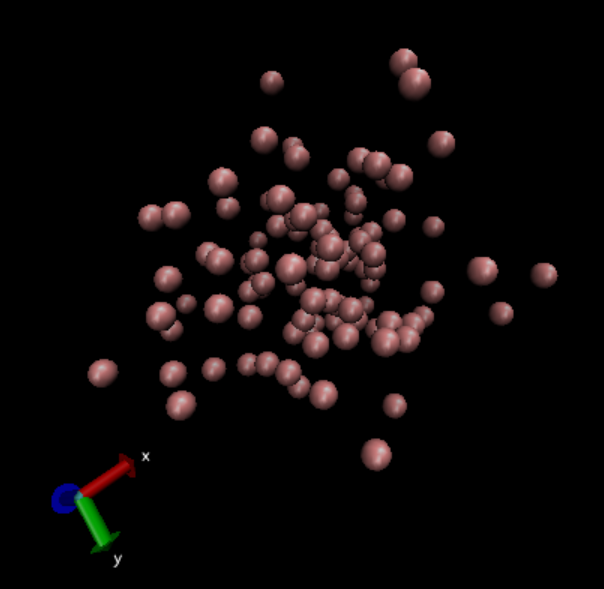

In [95]:
display.Image('./xyz_noPBC.png', width = 500)

In [38]:
#calculate <dr^2> as a function of dt
def selfDiffusivity(xyz):

    nFrames = xyz.shape[0]
    N = xyz.shape[1]
    
    diff_data = np.zeros(nFrames-1)
    
    for step in range(1, nFrames-1):
        
        delta_r = 0
        
        for i in range(0, nFrames-step):
            
            for atom in range(0, N):
    
                disp = dist_noPBC(xyz[i+step][atom,:], xyz[i][atom,:])
                
                delta_r += disp**2
        
        delta_r /= (nFrames-step)
        delta_r/= N
        diff_data[step] = delta_r
    
    return diff_data

In [39]:
#calculate <dr^2> for xyz_noPBC
d = selfDiffusivity(xyz_noPBC)

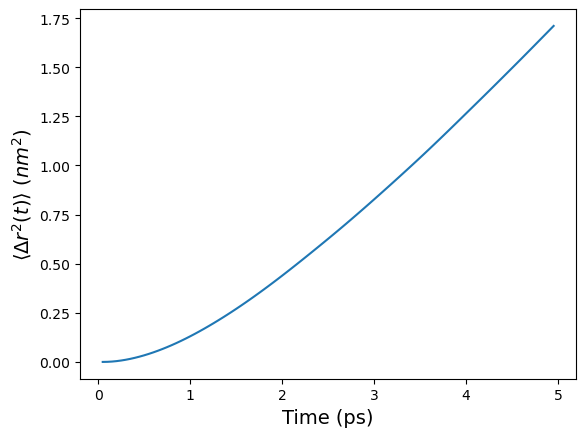

In [40]:
#plot <dr^2> as a function of t

dt = 0.05 #dt = 0.0005 * step size between frames (100)

dt_list = np.linspace(dt, dt*(nFrames-1), nFrames-1)

plt.plot(dt_list, d)
plt.xlabel("Time (ps)", fontsize=14)
plt.ylabel(r'$\langle \Delta r^{2}(t)\rangle$ ($nm^{2}$)', fontsize=14)
plt.show()

##### Short Times:

i) Physical Origin: The physical origin is the molecule at its inital random configuration of positions and velocities at an initial point in time (no prior molecule interaction). The first few picoseconds correspond to how the forces due to the positions and initial velocity magnitudes begin to drive the molecules to move and displace from their original configurations.

ii) Mathematical Explanation: Becasue the correlation depends on time difference and not time origin, the diffusivity will always begin at zero. The diffusivity then calculates the total displacement of a particle from its origin (initial position) over each time step. This is initially quadratic in nature when integrating over all particles because the diffusion experiences an initial "push" from the randomized forces and velocities such that the particles experience and quicker inital displacement (uneven force). This quadratic change in position with time can be thought of as an "acceleration" period due to the fact that particles flow from high chemical potential gradient to low chemical potential gradient. 

##### Intermediate Times:

i) Physical Origin: Since we are considering the true displacement without the box boundaries, the particles will eventually experience an equilibrated and constant motion. The physical origin of this period is when the kinetic movement and potential forces of the particles balance each other from the initializations. Fick's law allows us to calculate the diffusion coefficient since it states that diffusion flux is directly proportional to the concentration gradient.

ii) Mathematical Explanation: Once the forces balance more evenly, there is (on average) no net force in any directions, and the particles diffuse at a constant rate. This linear change in position with time can be thought of as the material's self-diffusive "velocity." This is where the self-diffusivity coeffecient should be calculated, under the assumption of equlibrated forces between the particles (aka when the chemical potential gradient = 0).

#####  Long Times:

Deviations: Self-diffusivity describes the random motion of a molecule in the absence of any gradients that would cause a mass flux. In the intermediate region, there is a constant concentration gradient, but eventually this steady state gradient can break down due to outside forces or reduced particle interaction as they begin to spread out. 

#### Linear Fit:

 
0.351 x - 0.6009


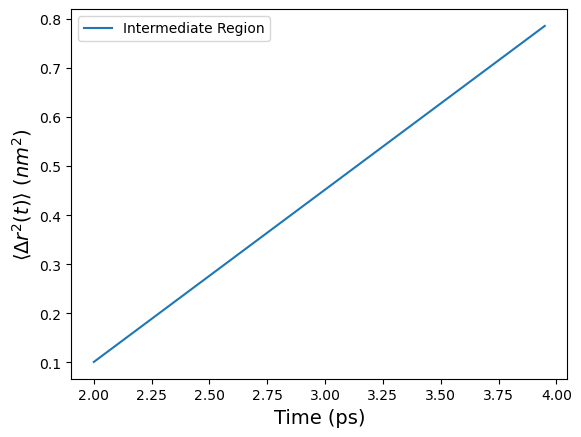

In [41]:
#perform linear fit to intermediaet-time linear region

dt_list_int = np.linspace(dt*40, dt*(nFrames-21), nFrames-60) #plot range frame:40->80; time:2ps->4ps

d2 = np.zeros(len(dt_list_int))

for i in range(len(dt_list_int)):
    d2[i] = d[i+19]
    
D = np.polyfit(dt_list_int, d2, 1)
p = np.poly1d(D)
plt.xlabel("Time (ps)", fontsize=14)
plt.ylabel(r'$\langle \Delta r^{2}(t)\rangle$ ($nm^{2}$)', fontsize=14)
plt.plot(dt_list_int, p(dt_list_int), label='Intermediate Region')
plt.legend()
eqn = np.poly1d(np.polyfit(dt_list_int, d2, 1))
print(eqn)

$\langle \Delta r^{2}(t)\rangle = 2dDt \rightarrow \frac{\langle \Delta r^{2}(t)\rangle}{t} = 2dD $, where $\frac{\langle \Delta r^{2}(t)\rangle}{t}$ is the slope of the intermediate region.

$\therefore \frac{0.351}{2d} = D = \frac{0.351}{2*3} \approx 0.06 \frac{nm^{2}}{ps} $ (self-diffusivity)